In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image as ImagePIL
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from google.colab import drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Spring 2025/QBIO 465/QBIO 465 FP/Original'
classes = ['Benign', 'Early', 'Pre', 'Pro']


In [ ]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

classes = ['Benign', 'Early', 'Pre', 'Pro']
data_dir = dataset_path

image_paths = []
labels = []

for cls in classes:
    cls_folder = os.path.join(data_dir, cls)

    if cls == 'Benign':

        folder_to_load = os.path.join(cls_folder, 'augmented')
    else:
        folder_to_load = cls_folder

    for fname in os.listdir(folder_to_load):
        if fname.endswith(".jpg"):
            image_paths.append(os.path.join(folder_to_load, fname))
            labels.append(cls)


In [ ]:
img_size = (224, 224)

def load_images(paths, size):
  images = []
  for path in paths:
    img = ImagePIL.open(path).resize(size)
    images.append(np.array(img))
  return np.array(images)

X = load_images(image_paths, img_size)
X = resnet_preprocess(X)


le = LabelEncoder()
y = le.fit_transform(labels)
y_cat = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (2921, 224, 224, 3)
Test shape: (731, 224, 224, 3)


In [ ]:
from collections import Counter
print(Counter(labels))

Counter({'Early': 985, 'Pre': 963, 'Benign': 900, 'Pro': 804})


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 49,279,108 (187.98 MB)

 Trainable params: 49,225,988 (187.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=50,
    callbacks=[early_stop]
)
model_save_path = '/content/drive/MyDrive/Spring 2025/QBIO 465/QBIO 465 FP/resnet50_augmented_model.h5'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")


Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 92s 387ms/step - accuracy: 0.3023 - loss: 2.6064 - val_accuracy: 0.5499 - val_loss: 1.2483
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.5552 - loss: 1.3494 - val_accuracy: 0.7305 - val_loss: 0.6747
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.6984 - loss: 0.8161 - val_accuracy: 0.8591 - val_loss: 0.3878
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.7755 - loss: 0.6178 - val_accuracy: 0.9029 - val_loss: 0.2686
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.8526 - loss: 0.3966 - val_accuracy: 0.9289 - val_loss: 0.2093
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8611 - loss: 0.3631 - val_accuracy: 0.9439 - val_loss: 0.1732
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8957 - loss: 0.2715 - val_accuracy: 0.9535 - val_loss: 0.1478
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9185 - loss: 0.2187 - val_accuracy: 0.9562 -

✅ Model saved to: /content/drive/MyDrive/Spring 2025/QBIO 465/QBIO 465 FP/resnet50_augmented_model.h5


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9928 - loss: 0.0275
Test Accuracy: 0.9863


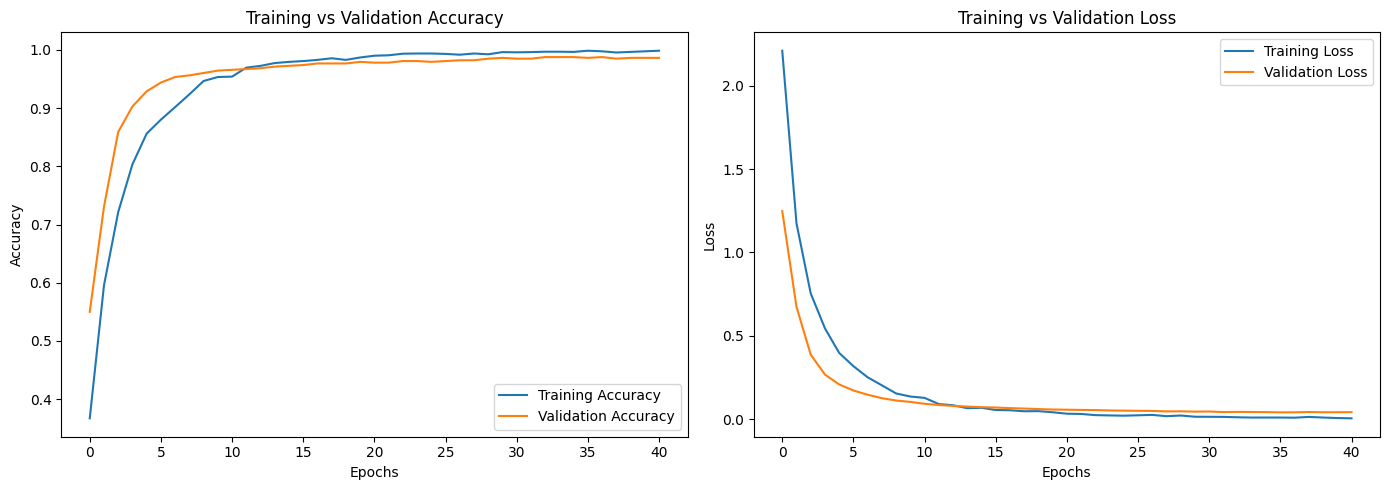

In [ ]:
plt.figure(figsize=(14, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_labels, target_names=le.classes_))

23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step
              precision    recall  f1-score   support

      Benign       0.97      0.98      0.98       180
       Early       0.98      0.97      0.97       197
         Pre       1.00      0.99      1.00       193
         Pro       1.00      1.00      1.00       161

    accuracy                           0.99       731
   macro avg       0.99      0.99      0.99       731
weighted avg       0.99      0.99      0.99       731



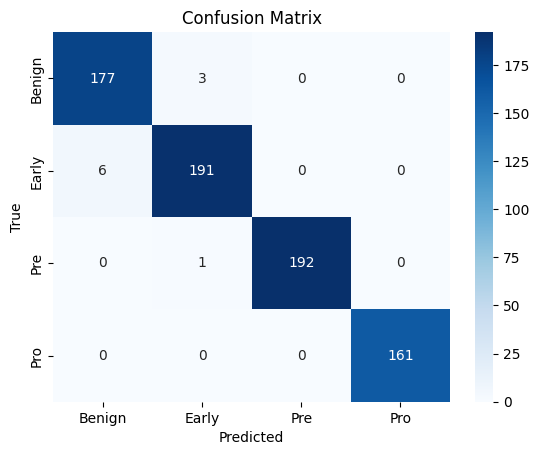

In [ ]:
cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('resnet50_confusion_matrix.png', dpi=300)
plt.show()

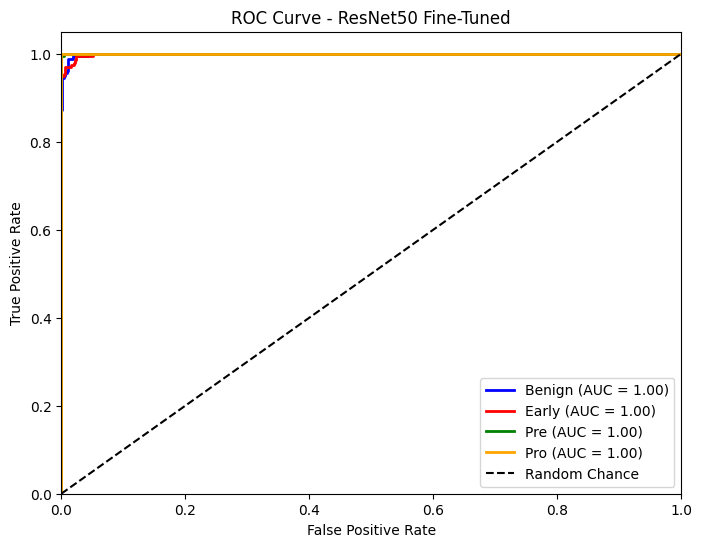

In [ ]:
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']

for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ResNet50 Fine-Tuned')
plt.legend(loc='lower right')
plt.savefig('resnet50_roc_curve.png', dpi=300)
plt.show()

## Grad-CAM

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from IPython.display import Image, display
from tensorflow.keras.models import load_model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Spring 2025/QBIO 465/QBIO 465 FP/resnet50_augmented_model.h5')
model.layers[-1].activation = None


In [ ]:
img_path = '/content/drive/MyDrive/Spring 2025/QBIO 465/QBIO 465 FP/Original/Pro/WBC-Malignant-Pro-001.jpg'
img_size = (224, 224)
last_conv_layer_name = 'conv5_block3_out'


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


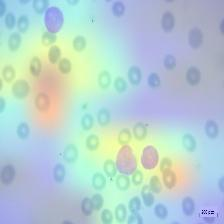

In [ ]:
"""
Grad-CAM Algorithm adapted from: https://keras.io/examples/vision/grad_cam/
"""

def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = tf.keras.applications.resnet50.preprocess_input(array)
    return np.expand_dims(array, axis=0)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_output = last_conv_output[0]
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = load_img(img_path)
    img = img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))

img_array = get_img_array(img_path, img_size)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(img_path, heatmap)

In [ ]:
img_size = (224, 224)
last_conv_layer_name = 'conv5_block3_out'
class_labels = le.classes_



In [ ]:
"""
Grad-CAM Algorithm adapted from: https://keras.io/examples/vision/grad_cam/
"""

def preprocess_img_array(img_array):
    return np.expand_dims(img_array, axis=0)


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_output = last_conv_output[0]
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds

def overlay_gradcam(original_img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)

    jet = mpl.colormaps['jet']
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((original_img.shape[1], original_img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + original_img
    return np.clip(superimposed_img / 255.0, 0, 1)



def generate_and_display_gradcam(index, X_test, y_test):

    global correct_predictions

    original_img = X_test[index]
    img_array = preprocess_img_array(original_img)

    heatmap, preds = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    predicted_label_index = np.argmax(preds[0])
    predicted_label = class_labels[predicted_label_index]
    true_label_index = np.argmax(y_test[index])
    true_label = class_labels[true_label_index]

    if predicted_label_index == true_label_index:
      correct_predictions += 1

    gradcam_overlay = overlay_gradcam(original_img, heatmap)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    axs[0].imshow(original_img.astype('uint8'))
    axs[0].set_title(f'Index: {index}\nTrue: {true_label}\nPredicted: {predicted_label}')
    axs[0].axis('off')

    axs[1].imshow(gradcam_overlay)
    axs[1].set_title(f'Grad-CAM Heatmap\nfor {predicted_label}')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
import random
correct_predictions = 0



selected_indices = random.sample(range(len(X_test)), 15)

for idx in selected_indices:
    generate_and_display_gradcam(idx, X_test, y_test)

print(f"Total correct predictions out of 15 images: {correct_predictions}")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import random

correct_predictions = 0

pro_indices = []
for i in range(len(X_test)):
    if np.argmax(y_test[i]) == np.where(class_labels == 'Pro')[0][0]:
        pro_indices.append(i)

selected_indices = random.sample(pro_indices, min(15, len(pro_indices)))

for idx in selected_indices:
    generate_and_display_gradcam(idx, X_test, y_test)

print(f"Total correct predictions out of {len(selected_indices)} Pro images: {correct_predictions}")


Output hidden; open in https://colab.research.google.com to view.